## Blackjack_ TD-SARSA

In [8]:
from enum import Enum
from copy import copy
import random
import numpy as np
from environment import *
import pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
import unittest


In [12]:
#Environment

class Color(Enum):
    RED = 0
    BLACK = 1

class Deck_of_Cards:
    def draw(self, color=None):
        return Card(color)

class Card:
    def __init__(self, color=None):
        self.value = self._random_value()
        if color:
            self.color = color
        else:
            self.color = self._random_color()

    def _random_color(self):
        random_value = random.random()
        if random_value < 1/3.0:
            return Color.RED
        return Color.BLACK

    def _random_value(self):
        return random.randint(1,10)

class Action(Enum):
    HIT = 0
    STAY = 1

class Reward(Enum):
    WIN = 1
    BUST = -1
    NONE = 0

class State:
    def __init__(self, total_dealer=0, total_player=0, end=False):
        self.total_dealer = total_dealer
        self.total_player = total_player
        self.end = end

class Environment:

    def __init__(self):
        self.Deck_of_Cards = Deck_of_Cards()
        self.max_total_dealer = 10
        self.max_total_player = 21
        self.num_of_actions = len(Action)

    def init_state(self):
        self.done = False
        dealer_value = self._draw_and_get_value(Color.BLACK)
        player_value = self._draw_and_get_value(Color.BLACK)
        return State(dealer_value, player_value)

    def _draw_and_get_value(self, color=None):
        card = self.Deck_of_Cards.draw(color)
        multiplier = 1 if card.color == Color.BLACK else -1
        return multiplier * card.value

    def step(self, state, action):
        next_state, reward = None, Reward.NONE
        if action == Action.HIT:
            next_state, reward = self._player_hit(state)
        else:
            next_state, reward = self._dealer_play(state)
        return next_state, reward

    def _player_hit(self, state):
        next_state = copy(state)
        next_state.total_player += self._draw_and_get_value()
        next_state.end = self._is_bust(next_state.total_player)
        reward = Reward.BUST if next_state.end else Reward.NONE
        return next_state, reward

    def _is_bust(self, cards_sum):
        return cards_sum < 1 or cards_sum > 21

    def _dealer_play(self, state):
        next_state = copy(state)
        action = None
        while not next_state.end and action != Action.STAY:
            action = self._dealer_next_action(next_state.total_dealer)
            if action == Action.HIT:
                next_state.total_dealer += self._draw_and_get_value()
            next_state.end = self._is_bust(next_state.total_dealer)	
            reward = Reward.WIN if next_state.end else self._get_reward_dealer_STAY(next_state)
            next_state.end = True
        return next_state, reward

    def _dealer_next_action(self, total_dealer):
        return Action.HIT if total_dealer < 17 else Action.STAY

    def _get_reward_dealer_STAY(self, state):
        if state.total_player > state.total_dealer:
            return Reward.WIN
        elif state.total_player < state.total_dealer:
            return Reward.BUST
        else:
            return Reward.NONE

        #Agent





In [13]:
class RLAgent:
    def __init__(self, environment, N0=100, discount_factor=1, _lambda=0.1):
        self.env = environment
        self.N0 = N0
        self.discount_factor = discount_factor
        self._lambda = _lambda

    def _init_tenor(self):
        return np.zeros((self.env.max_total_dealer + 1, self.env.max_total_player + 1, self.env.num_of_actions))

    def _get_alpha(self, s, a):
        return 1/self.returns_count[s.total_dealer][s.total_player][a]

    def _get_epsilon(self, s):
        epsilon = self.N0/(self.N0 + sum(self.returns_count[s.total_dealer][s.total_player]))
        return epsilon

    def get_value_function(self, Q):
        V = np.zeros([self.env.max_total_dealer + 1, self.env.max_total_player + 1])
        for d in range(1, self.env.max_total_dealer + 1):
            for p in range(1, self.env.max_total_player + 1):
                V[d][p] = self._get_value(State(d, p), Q)#np.max(Q[d][p])
        return V 

    def _get_value(self, s, Q):
        return np.max(Q[s.total_dealer][s.total_player])



In [10]:
#Sarsa Agent
class TDSarsaAgent(RLAgent):

    def __init__(self, environment, N0=100, discount_factor=1, _lambda=1):
        super().__init__(environment, N0, discount_factor, _lambda)
        self.Q = self._init_tenor()
        self.returns_count = self._init_tenor()

    def train(self, num_episodes=10):
        for e in range(num_episodes):
            E = self._init_tenor()
            s = self.env.init_state()
            a = self._policy(s)
            while not s.end:
                self.returns_count[s.total_dealer][s.total_player][a] += 1
                next_s, r = self.env.step(s, Action(a))
                next_a = self._policy(next_s)
                td_delta = self._td_delta(s, a, next_s, next_a, r)
                E[s.total_dealer][s.total_player][a] += 1
                self.Q += self._get_alpha(s, a)*td_delta*E
                E = self.discount_factor*self._lambda*E
                s = next_s
                a = next_a
                
            if e % 10 == 0:
                print("\rEpisode {}/{}.".format(e, num_episodes), end="")


        return self.Q

    def _policy(self, s):
        if s.end: return None
        num_of_actions = len(Action)
        epsilon = self._get_epsilon(s)
        state_actions = np.ones(num_of_actions, dtype=float) * epsilon/num_of_actions
        greedy_action = np.argmax(self.Q[s.total_dealer][s.total_player])
        state_actions[greedy_action] += (1.0 - epsilon)
        action = np.random.choice(np.arange(len(state_actions)), p=state_actions)
        return action


    def _td_delta(self, s, a, next_s, next_a, r):
        if next_s.end:
            return r.value - self.Q[s.total_dealer][s.total_player][a]
        else:
            return (r.value + self.discount_factor*self.Q[next_s.total_dealer][next_s.total_player][next_a]) - self.Q[s.total_dealer][s.total_player][a]





In [11]:
#Calc
class TDSarsaApproxAgent(RLAgent):

    def __init__(self, environment, N0=100, discount_factor=1, _lambda=1):
        super().__init__(environment, N0, discount_factor, _lambda)
        self.dealer_intervals = {(1,4), (4,7), (7,10)}
        self.player_intervals = {(1,6), (4,9), (7,12), (10,15), (13,18), (16,21)}
        self.num_features = len(self.dealer_intervals)*len(self.player_intervals)*self.env.num_of_actions
        self.theta = np.random.randn(self.num_features) * 0.1

    def _init_feature_tenor(self):
        return np.zeros(self.num_features)

    def train(self, num_episodes=10):
        for e in range(num_episodes):
            E = self._init_feature_tenor()
            s = self.env.init_state()
            a = self._policy(s)
            while not s.end:
                next_s, r = self.env.step(s, Action(a))
                next_a = self._policy(next_s)
                phi = self._get_phi(s, a)
                q = self._get_Q(phi)
                td_delta = self._td_delta(next_s, next_a, r, q)
                E += phi
                self.theta += (self._get_alpha(s, a)*td_delta*E)
                E *= (self.discount_factor*self._lambda)
                s = next_s
                a = next_a
                
            if e % 10 == 0:
                print("\rEpisode {}/{}.".format(e, num_episodes), end="")
                
        self.Q = self._get_all_Q()
        return self.Q

    def _policy(self, s):
        if s.end: return None
        if random.random() < self._get_epsilon(s):
            return self._get_random_action()
        else:
            return self._get_greedy_action(s)

    def _get_epsilon(self, s):
        return 0.05

    def _get_random_action(self):
        return Action.HIT.value if random.random() <= 0.5 else Action.STAY.value

    def _get_greedy_action(self, s):
        return np.argmax([self._get_Q(self._get_phi(s, a.value)) for a in Action])

    def _get_phi(self, s, a):
        dealer_nonzero_features = np.where([i[0] <= s.total_dealer <= i[1] for i in self.dealer_intervals])
        player_nonzero_features = np.where([i[0] <= s.total_player <= i[1] for i in self.player_intervals])
        phi = np.zeros((len(self.dealer_intervals), len(self.player_intervals), self.env.num_of_actions), dtype=np.int)
        phi[dealer_nonzero_features, player_nonzero_features, a] = 1
        return phi.flatten()

    def _get_Q(self, phi):
        return np.dot(phi, self.theta)

    def _td_delta(self, next_s, next_a, r, q):
        if next_s.end:
            return r.value - q
        else:
            next_q = self._get_Q(self._get_phi(next_s, next_a))
            return (r.value + self.discount_factor*next_q) - q

    def _get_alpha(self, s, a):
        return 0.01

    def _get_all_Q(self):
        all_q = self._init_tenor()
        for d in range(1, self.env.max_total_dealer + 1):
            for p in range(1, self.env.max_total_player + 1):
                for a in Action:
                    s = State(d, p)
                    phi = self._get_phi(s, a.value)
                    all_q[d, p, a.value] = self._get_Q(phi)
        return all_q


Episode 4990/5000.

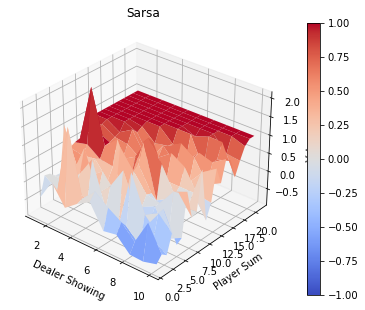

In [17]:
#plotting

def dump(Q, file_path):
  with open(file_path, 'wb') as file:
    pickle.dump(Q, file)


def load_dump(file_path):
  with open(file_path, 'rb') as file:
    return pickle.load(file)

def plot_value_function(V, title="Value Function"):
    min_x = 1
    max_x = V.shape[0]
    min_y = 1
    max_y = V.shape[1]

    x_range = np.arange(min_x, max_x)
    y_range = np.arange(min_y, max_y)
    X, Y = np.meshgrid(x_range, y_range)
    Z = V[X, Y]

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -50)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z, title)


def plot_error_vs_episode(sqrt_error, lambdas, num_train=1000000, num_episodes=1000,
                          title='MSE vs Epoch', save_as_file=False):
    assert num_episodes != 0
    x_range = np.arange(0, num_train*num_episodes, num_episodes)
    
    assert len(sqrt_error) == len(lambdas)
    for e in sqrt_error:
        print(len(e), len(x_range))
        assert num_train == len(e)
    
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)
    ax.set_ylabel('MSE')
    ax.set_xlabel('Epoch Number')

    for i in range(len(sqrt_error)-1, -1, -1):
    	ax.plot(x_range, sqrt_error[i], label='λ {}'.format(lambdas[i]))
    
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

    if save_as_file:
        plt.savefig(title)
   
    plt.show()

def plot_error_vs_lambda(sqrt_error, lambdas, title='MSE vs λ', save_as_file=False):

    assert len(sqrt_error) == len(lambdas)

    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)
    ax.set_ylabel('MSE')
    ax.set_xlabel('λ')
    y = [s[-1] for s in sqrt_error]
    ax.plot(lambdas, y)
    
    if save_as_file:
        plt.savefig(title)
    
    plt.show()


def mean_squared_error(true_Q, Agent, environment, lambdas, num_episodes=1000, num_train=10):
    errors = []
    for l in lambdas:
        error = []
        agent = Agent(environment, _lambda=l)
        for j in range(num_train):
            Q = agent.train(num_episodes)
            error.append(np.square(np.subtract(true_Q, Q)).mean())
        errors.append(error)
    return errors

env = Environment()
sarsa_agent = TDSarsaAgent(env, _lambda=1)
Q = sarsa_agent.train(5000)
V = sarsa_agent.get_value_function(Q)
plot_value_function(V, title="Sarsa")

Episode 9990/10000.

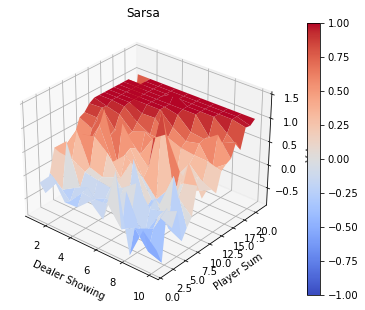

In [20]:
env = Environment()
sarsa_agent = TDSarsaAgent(env, _lambda=1)
Q = sarsa_agent.train(10000)
V = sarsa_agent.get_value_function(Q)
plot_value_function(V, title="Sarsa")